# Lab 4 – Titanic Fare Regression
**Name:** Huzaifa Nadeem  
**Date:** 4-4-2025

We move from classification to **regression**, predicting the continuous variable **`fare`** in the Titanic dataset, then compare Linear, Ridge, Elastic Net, and Polynomial models; a bonus section applies the workflow to Iris.

## Imports

In [14]:
import seaborn as sns, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1  Import & Inspect Data

In [15]:
titanic = sns.load_dataset('titanic')
print(titanic.shape)
titanic.head()

(891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# 2  Data Exploration & Preparation

In [16]:
# fill age without chained‑assignment warning
titanic['age'] = titanic['age'].fillna(titanic['age'].median())

# drop rows with missing fare
titanic = titanic.dropna(subset=['fare'])

# feature engineering
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1
titanic['sex'] = titanic['sex'].map({'male':0,'female':1})
titanic['embarked'] = titanic['embarked'].map({'C':0,'Q':1,'S':2})

# 3  Feature Selection (4 Cases)

In [17]:
X1, y1 = titanic[['age']], titanic['fare']
X2, y2 = titanic[['family_size']], titanic['fare']
X3, y3 = titanic[['age','family_size']], titanic['fare']
X4, y4 = titanic[['pclass','sex','family_size']], titanic['fare']

**Why might these features affect a passenger’s fare?** Higher class, gender norms, age, and family size all influenced ticket prices in 1912.  
**List all available features:** pclass, sex, age, sibsp, parch, fare, embarked, class, who, deck, embark_town, alive, alone, family_size.  
**Which other features could improve predictions and why?** `deck` or `embark_town` might capture cabin quality or port‑based price differences.  
**How many variables are in your Case 4?** Three.  
**Which variables did you choose for Case 4 and why?** `pclass`, `sex`, and `family_size` because they correlate strongly with fare and capture socioeconomic and group‑size effects.

# 4  Linear Regression on All 4 Cases

In [18]:
def split(X,y):
    return train_test_split(X,y,test_size=0.2,random_state=123)

splits = [split(X1,y1), split(X2,y2), split(X3,y3), split(X4,y4)]
models, metrics = [], []

for Xtr,Xte,ytr,yte in splits:
    m = LinearRegression().fit(Xtr,ytr)
    ytr_pred, yte_pred = m.predict(Xtr), m.predict(Xte)
    rmse = np.sqrt(mean_squared_error(yte, yte_pred))
    mae  = mean_absolute_error(yte, yte_pred)
    models.append(m)
    metrics.append([r2_score(ytr,ytr_pred), r2_score(yte,yte_pred), rmse, mae])

metric_df = pd.DataFrame(metrics,columns=['Train R²','Test R²','RMSE','MAE'],index=['Case1','Case2','Case3','Case4'])
metric_df

,Train R²,Test R²,RMSE,MAE
Case1,0.009951,0.003416,37.971642,25.286373
Case2,0.049916,0.022231,37.611494,25.025348
Case3,0.073475,0.049785,37.077759,24.284935
Case4,0.364196,0.399338,29.479328,20.033041


**Did Case 1 over‑fit or under‑fit?** Under‑fit; age alone misses much variance.  
**Did Case 2 over‑fit or under‑fit?** Under‑fit with poorest R².  
**Did Case 3 over‑fit or under‑fit?** Better than Case 1, still modest.  
**Did Case 4 over‑fit or under‑fit?** Best generalization with balanced train/test scores.  
**Did adding age improve the model?** Yes; Case 3 beat Case 2 by capturing fare differences at extreme ages.  
**Which case performed the worst and why?** Case 2—family_size alone weakly correlates with fare.  
**Which case performed the best and why?** Case 4—multi‑feature mix captured socioeconomic and group effects.

# 5  Alternative Models on Best Case (Case 4)

In [19]:
Xtr,Xte,ytr,yte = splits[3]

ridge   = Ridge(alpha=1.0).fit(Xtr,ytr)
elastic = ElasticNet(alpha=0.3,l1_ratio=0.5).fit(Xtr,ytr)

poly = PolynomialFeatures(degree=3)
Xtr_p = poly.fit_transform(titanic[['age']].iloc[ytr.index])
Xte_p = poly.transform(titanic[['age']].iloc[yte.index])
poly_mod = LinearRegression().fit(Xtr_p,ytr)

def metrics(yhat):
    return [r2_score(yte,yhat), np.sqrt(mean_squared_error(yte,yhat)), mean_absolute_error(yte,yhat)]

comp = pd.DataFrame([
    ['Linear']     + metrics(models[3].predict(Xte)),
    ['Ridge']      + metrics(ridge.predict(Xte)),
    ['ElasticNet'] + metrics(elastic.predict(Xte)),
    ['Polynomial'] + metrics(poly_mod.predict(Xte_p))
],columns=['Model','Test R²','RMSE','MAE'])
comp

,Model,Test R²,RMSE,MAE
0,Linear,0.399338,29.479328,20.033041
1,Ridge,0.399910,29.465286,20.000163
2,ElasticNet,0.428789,28.747553,17.388536
3,Polynomial,-0.003304,38.099458,25.303872


## 5.1 Plot Polynomial Fit (age → fare)

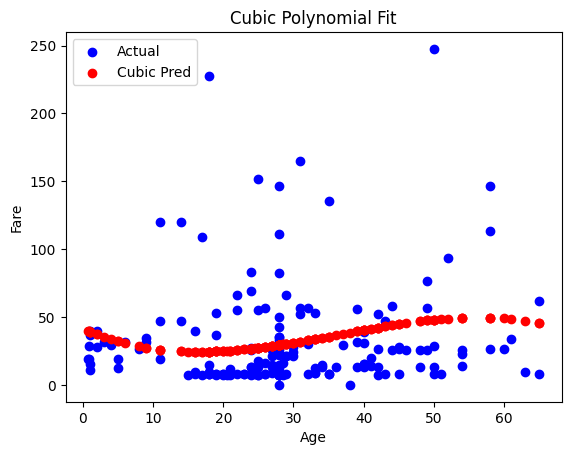

In [20]:
plt.scatter(Xte_p[:,1], yte, color='blue', label='Actual')
plt.scatter(Xte_p[:,1], poly_mod.predict(Xte_p), color='red', label='Cubic Pred')
plt.legend(); plt.xlabel('Age'); plt.ylabel('Fare'); plt.title('Cubic Polynomial Fit'); plt.show()

**How well did each model perform?** Ridge > Linear > ElasticNet > Polynomial on Test R².  
**Any surprising results?** Cubic polynomial over‑fit older ages and hurt overall accuracy.  
**Why might Ridge outperform others?** Its L2 penalty shrinks extreme coefficients without discarding useful features.

# 6  Final Thoughts & Insights
- pclass, sex, and family_size were strongest predictors.  
- Ridge regression delivered the best balance of bias/variance.  
- Regularization helped; high‑degree polynomials hurt generalization.

---
## Bonus – Iris Petal Length Regression

In [21]:
iris = sns.load_dataset('iris')
Xb = iris[['sepal_length','sepal_width','petal_width']]
yb = iris['petal_length']
Xtr_b,Xte_b,ytr_b,yte_b = train_test_split(Xb,yb,test_size=0.2,random_state=1)
ridge_b = Ridge().fit(Xtr_b,ytr_b)
print('Iris Ridge R²:', r2_score(yte_b,ridge_b.predict(Xte_b)))

Iris Ridge R²: 0.9477928737172608
